In [16]:
# Import libraries and dependencies
import ccxt
import os
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pickle as pk

import pandas as pd
from dotenv import load_dotenv

In [17]:
# Load environment variables
load_dotenv()

# Import environment variables
kraken_public = os.getenv("KRAKEN_PUBLIC_KEY")
kraken_secret = os.getenv("KRAKEN_SECRET_KEY")
alpha_key = os.getenv("AV_API_KEY")

# Verify that environment variables were loaded
print(f"Kraken key data type: {type(kraken_public)}")
print(f"Kraken secret data type: {type(kraken_secret)}")
print(f"Alpha key data type: {type(alpha_key)}")

Kraken key data type: <class 'str'>
Kraken secret data type: <class 'str'>
Alpha key data type: <class 'str'>


In [18]:
# Set the public and private keys for the API
exchange = ccxt.kraken({
    'apiKey': kraken_public,
    'secret': kraken_secret,
})

In [19]:
# Fetch daily candlestick bar data from `BTC/USD`
eth_prices = exchange.fetch_ohlcv("ETH/USD", "1d")
# Import the data as a Pandas DataFrame and set the columns
eth_df = pd.DataFrame(
    eth_prices, columns=["date", "open", "high", "low", "close", "volume"]
)
eth_df

,date,open,high,low,close,volume
0,1556755200000,158.22,160.51,154.60,158.81,24532.066011
1,1556841600000,158.67,169.00,157.93,164.52,42707.778195
2,1556928000000,164.78,168.87,158.05,161.95,34581.592498
3,1557014400000,161.94,163.52,157.12,161.34,13915.325512
4,1557100800000,161.35,175.95,157.00,171.20,64032.242537
...,...,...,...,...,...,...
715,1618531200000,2517.11,2548.53,2308.00,2426.14,94809.867394
716,1618617600000,2425.99,2496.82,2315.55,2318.27,55680.769060
717,1618704000000,2319.15,2339.78,1950.00,2242.17,162476.612347
718,1618790400000,2240.98,2279.66,2079.90,2162.94,83836.511015


In [15]:
# Convert epoch timestamp to date using the `to_datetime` function and `unit` parameter
# eth_df["date"] = pd.to_datetime(eth_df["date"], unit="ms")
# eth_df.set_index(eth_df["date"], inplace=True)
# eth_df.drop(columns=["date"], inplace=True)
# eth_df.head()

In [20]:
# Define functions for SMA, RSI
def compute_sma(df, window, colname):
    # Computes simple moving average column on the dataframe
    df[colname] = df["close"].rolling(window=window, center=False).mean()
    return(df)

def compute_rsi(df, window, colname):
    # Computes RSI column for a dataframe
    series = df["close"]
    delta = series.diff().dropna()
    u = delta * 0
    d = u.copy()
    u[delta > 0] = delta[delta > 0]
    d[delta < 0] = -delta[delta < 0]
    # sum of average gains
    u[u.index[window - 1]] = np.mean(u[:window])
    u = u.drop(u.index[:(window - 1)])
    # sum of average losses
    d[d.index[window - 1]] = np.mean(d[:window])
    d = d.drop(d.index[:(window - 1)])
    rs = u.ewm(com=window - 1,ignore_na=False,
              min_periods=0,adjust=False).mean() / d.ewm(com=window - 1, ignore_na=False, min_periods=0, adjust=False).mean()
    df[colname] = 100 - 100 / (1 + rs)
    df[colname].fillna(df[colname].mean(), inplace=True)
    return(df)

In [21]:
def compute_variables(df):
    df["date"] = pd.to_datetime(df["date"])
    df["bodysize"] = df["close"] - df["open"]
    df["shadowsize"] = df["high"] - df["low"]
    for window in [20, 50, 100]:
        df = compute_sma(df, window, colname="sma_{}".format(window))
        df = compute_rsi(df, window, colname="rsi_{}".format(window))
        df["Min_{}".format(window)] = df["low"].rolling(window).min()
        df["Max_{}".format(window)] = df["high"].rolling(window).max()
        df["volume_{}".format(window)] = df["volume"].rolling(window).mean()
        df['percentChange_{}'.format(window)] = df['close'].pct_change(periods = window)
        df['RelativeSize_sma_{}'.format(window)] = df['close'] / df['sma_{}'.format(window)]
        df['Diff_{}'.format(window)] = df['close'].diff(window)
    
    df["WeekDay"] = df["date"].dt.weekday
    df["Day"] = df["date"].dt.day
    df.dropna(inplace=True) 
    
    return(df)

In [22]:
df = compute_variables(eth_df)
df

,date,open,high,low,close,volume,bodysize,shadowsize,sma_20,rsi_20,...,sma_100,rsi_100,Min_100,Max_100,volume_100,percentChange_100,RelativeSize_sma_100,Diff_100,WeekDay,Day
100,1970-01-01 00:26:05.395200,210.24,214.78,201.00,206.05,33943.315981,-4.19,13.78,217.1875,40.259811,...,245.9942,52.615667,157.0,363.29,72531.911854,0.297462,0.837621,47.24,3,1
101,1970-01-01 00:26:05.481600,206.02,216.63,205.69,216.28,34123.159410,10.26,10.94,217.1380,44.469224,...,246.5118,53.151756,157.0,363.29,72446.065666,0.314612,0.877362,51.76,3,1
102,1970-01-01 00:26:05.568000,216.28,216.45,209.70,211.20,18066.456673,-5.08,6.75,217.0955,42.889538,...,247.0043,52.851830,157.0,363.29,72280.914307,0.304106,0.855046,49.25,3,1
103,1970-01-01 00:26:05.654400,211.19,211.94,203.00,208.60,34698.784821,-2.59,8.94,216.7000,42.084130,...,247.4769,52.698097,157.0,363.29,72488.748901,0.292922,0.842907,47.26,3,1
104,1970-01-01 00:26:05.740800,208.40,209.00,182.00,186.20,59075.037504,-22.20,27.00,215.0520,35.960114,...,247.6269,51.397076,163.5,363.29,72439.176850,0.087617,0.751938,15.00,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,1970-01-01 00:26:58.531200,2517.11,2548.53,2308.00,2426.14,94809.867394,-90.97,240.53,2093.9110,66.439310,...,1674.0224,61.589825,700.0,2548.53,110127.956422,1.002013,1.449288,1214.29,3,1
716,1970-01-01 00:26:58.617600,2425.99,2496.82,2315.55,2318.27,55680.769060,-107.72,181.27,2125.5255,61.532127,...,1684.9433,60.275110,700.0,2548.53,108496.379602,0.890644,1.375874,1092.09,3,1
717,1970-01-01 00:26:58.704000,2319.15,2339.78,1950.00,2242.17,162476.612347,-76.98,389.78,2146.8185,58.332648,...,1695.1917,59.371974,700.0,2548.53,107587.710704,0.841875,1.322665,1024.84,3,1
718,1970-01-01 00:26:58.790400,2240.98,2279.66,2079.90,2162.94,83836.511015,-78.04,199.76,2162.8810,55.187786,...,1704.0168,58.450938,700.0,2548.53,107143.767572,0.689229,1.269318,882.51,3,1


In [23]:
df.to_csv("./Data/DatasetWithVariables.csv", index=False)

In [24]:
# Define stoploss and take profit
stoploss = .05
takeprofit = .12

# Compute the outputs
def check_outcome(df, line, stoploss, takeprofit):
    # 0 means we reach stoploss
    # 1 means we reach takeprofit
    # -1 means we are holding
    price0 = df["close"].iloc[line]
    upper_lim = price0*(1+takeprofit)
    down_lim = price0*(1-stoploss)
    for i in range(line, df["close"].size):
        if df["low"].iloc[i] < down_lim:
            return(0)
        elif df["high"].iloc[i] > upper_lim:
            return(1)
    return(-1)

def compute_result(df, stoploss, takeprofit):
    df["result"] = 0
    for i in range(df["close"].size):
        if i%500 == 0:
            print(i, '/', df.shape[0])
        df["result"].iloc[i] = check_outcome(df, i, stoploss, takeprofit)
    return(df)

In [25]:
df = compute_result(df, stoploss, takeprofit)
df = df[df["result"]>=0]
df.to_csv("./Data/DatasetWithVariablesAnd_stoploss{}_takeprofit{}.csv".format(stoploss, takeprofit), index=False)
df.head()

0 / 620


/Users/jacobjalomo/opt/anaconda3/envs/algotrading/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


500 / 620


,date,open,high,low,close,volume,bodysize,shadowsize,sma_20,rsi_20,...,rsi_100,Min_100,Max_100,volume_100,percentChange_100,RelativeSize_sma_100,Diff_100,WeekDay,Day,result
100,1970-01-01 00:26:05.395200,210.24,214.78,201.00,206.05,33943.315981,-4.19,13.78,217.1875,40.259811,...,52.615667,157.0,363.29,72531.911854,0.297462,0.837621,47.24,3,1,0
101,1970-01-01 00:26:05.481600,206.02,216.63,205.69,216.28,34123.159410,10.26,10.94,217.1380,44.469224,...,53.151756,157.0,363.29,72446.065666,0.314612,0.877362,51.76,3,1,0
102,1970-01-01 00:26:05.568000,216.28,216.45,209.70,211.20,18066.456673,-5.08,6.75,217.0955,42.889538,...,52.851830,157.0,363.29,72280.914307,0.304106,0.855046,49.25,3,1,0
103,1970-01-01 00:26:05.654400,211.19,211.94,203.00,208.60,34698.784821,-2.59,8.94,216.7000,42.084130,...,52.698097,157.0,363.29,72488.748901,0.292922,0.842907,47.26,3,1,0
104,1970-01-01 00:26:05.740800,208.40,209.00,182.00,186.20,59075.037504,-22.20,27.00,215.0520,35.960114,...,51.397076,163.5,363.29,72439.176850,0.087617,0.751938,15.00,3,1,1


In [26]:
# Create splits for train, test, validation
split1 = int(.65*len(df))

trainset = df[:split1]
valtest = df[split1:]

split2 = int(.5*len(valtest)) # split remaining data into 50% for validation and test

valset = valtest[:split2]
testset = valtest[split2:]

# Create files
trainset.to_csv('./Data/TrainSet_stoploss{}_takeprofit{}.csv'.format(stoploss, takeprofit), index = False)
valset.to_csv('./Data/ValidationSet_stoploss{}_takeprofit{}.csv'.format(stoploss, takeprofit), index = False)
testset.to_csv('./Data/TestSet_stoploss{}_takeprofit{}.csv'.format(stoploss, takeprofit), index = False)

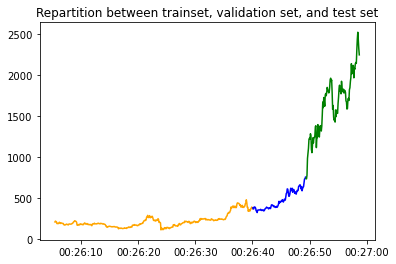

In [27]:
# Display the splitting
plt.plot(pd.to_datetime(trainset['date']), trainset['close'], c = 'orange')
plt.plot(pd.to_datetime(valset['date']), valset['close'], c = 'b')
plt.plot(pd.to_datetime(testset['date']), testset['close'], c = 'g')
plt.title('Repartition between trainset, validation set, and test set')
plt.show()

In [28]:
# (i) Scale the variables
scale_fct = StandardScaler()
scale_fct.fit(trainset.drop('date', 1).drop('result', 1))
pk.dump(scale_fct, open('./Models/scaler.pkl','wb'))

# (ii) Apply PCA
pca = PCA(n_components=trainset.shape[1] - 2) # remove the result and the date
pca.fit(scale_fct.transform(trainset.drop('date', 1).drop('result', 1)))
pk.dump(pca, open('./Models/pca.pkl',"wb"))

# (iii) Scale PCA components (this accelerates training process in Deep Learning)
pca_scaler = StandardScaler()
pca_scaler.fit(pca.transform(scale_fct.transform(trainset.drop('date', 1).drop('result', 1))))
pk.dump(pca_scaler, open('./Models/pca_scaler.pkl','wb'))

In [29]:
# (iv) Save ready-to-use versions (i.e. datasets after applying scalers and PCA)
trainset_final = pd.DataFrame(pca_scaler.transform(pca.transform(scale_fct.transform(trainset.drop('date', 1).drop('result', 1)))))
validation_set_final = pd.DataFrame(pca_scaler.transform(pca.transform(scale_fct.transform(valset.drop('date', 1).drop('result', 1)))))
testset_final = pd.DataFrame(pca_scaler.transform(pca.transform(scale_fct.transform(testset.drop('date', 1).drop('result', 1)))))

trainset_final.to_csv('./Data/TrainSet_final_stoploss{}_takeprofit{}.csv'.format(stoploss, takeprofit), index = False)
validation_set_final.to_csv('./Data/ValidationSet_final_stoploss{}_takeprofit{}.csv'.format(stoploss, takeprofit), index = False)
testset_final.to_csv('./Data/TestSet_final_stoploss{}_takeprofit{}.csv'.format(stoploss, takeprofit), index = False)